## Config

# Basic config

In [1]:
capture_image_from_webcam = True
gdrive_products_path = "D:\Other\People\Dula\Experiment\Products"
get_config_from_gdrive_file = True
BASE_PATH = "D:\Other\People\Dula\Experiment\Local Jupyter"

In [2]:
# Person image variables
detected_face_radius_multiplier = 1.5

In [3]:
import json

manualJsonConfig = """
[
    {
        "imageName": "nonpclock.png",
        "personImage": null
    },
    {
        "imageName": "pwallclock.png",
        "personImage": {
            "center": {
                "x": 250,
                "y": 195
            },
            "size": {
                "max_width": 60,
                "max_height": 60
            }
        }
    },
    {
        "imageName": "pmilkpowder.png",
        "personImage": {
            "center": {
                "x": 201,
                "y": 229
            },
            "size": {
                "max_width": 130,
                "max_height": 130
            }
        }
    }
]
"""

Other Config. No need to change for execution

In [4]:
person_image_folder_path = BASE_PATH + '/content/PersonImage'
person_image_mask_folder_path = BASE_PATH + '/content/PersonImageMask'

background_remover_input_folder_path = BASE_PATH + '/content/MODNet/demo/image_matting/colab/input'
background_remover_output_folder_path = BASE_PATH + '/content/MODNet/demo/image_matting/colab/output'

products_image_path = BASE_PATH + '/products'
products_image_config_file_name = "image_generation_config.json"

personalized_image_output_path = BASE_PATH + '/content/PersonalizedImageOutput'

face_detection_classifier_path = products_image_path + "/src/haarcascade_frontalface_default.xml"

## Setup

In [5]:
# Folder Structure Setup
import os.path
from os import path
import shutil

rebuild_folder_paths = [person_image_folder_path, person_image_mask_folder_path, personalized_image_output_path]

# clean and rebuild the folders
for folder_path in rebuild_folder_paths:
  if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
  os.makedirs(folder_path)

In [6]:
for folder_path in rebuild_folder_paths:
  if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
  os.makedirs(folder_path)

In [7]:
# Background remover setup

import os
import shutil
# from google.colab import files

# clone the repository
os.chdir(BASE_PATH + "/content")
if not os.path.exists('MODNet'):
  !git clone https://github.com/MaheeGamage/MODNet
os.chdir(BASE_PATH + "/content/MODNet/")

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1uXRxXvizrwSj9-FlxqEuwDIhkb9E28y5 \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

# clean and rebuild the image folders
if os.path.exists(background_remover_input_folder_path):
  shutil.rmtree(background_remover_input_folder_path)
os.makedirs(background_remover_input_folder_path)

if os.path.exists(background_remover_output_folder_path):
  shutil.rmtree(background_remover_output_folder_path)
os.makedirs(background_remover_output_folder_path)

In [8]:
import shutil
import os
from glob import glob

def getFilesPathInFolder(path):
  glob_pattern = os.path.join(path, '*')
  return glob(glob_pattern)

In [9]:
import cv2

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [10]:
import cv2

def resize_image_with_max_height_and_width(img, max_width=None, max_height=None):
    # Get the dimensions of the original image
    height, width = img.shape[:2]

    # Check if either max_width or max_height was provided
    if max_width is None and max_height is None:
        return img

    # Calculate the scaling factor needed to fit the image within the constraints
    width_scaling_factor = max_width / width if max_width else 1
    height_scaling_factor = max_height / height if max_height else 1
    scaling_factor = min(width_scaling_factor, height_scaling_factor)

    # Resize the image using the scaling factor
    new_width = int(width * scaling_factor)
    new_height = int(height * scaling_factor)
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return resized_img


In [11]:
def calculateOffset(input_config, img):
  x_offset, y_offset = 0,0
  if 'offset' in input_config['personImage']:
    x_offset=input_config['personImage']['offset']['x_offset']
    y_offset=input_config['personImage']['offset']['y_offset']
  elif 'center' in input_config['personImage']:
    x_offset = int(input_config['personImage']['center']['x'] - (img.shape[0] / 2))
    y_offset = int(input_config['personImage']['center']['y'] - (img.shape[1] / 2))

  return (x_offset, y_offset)

In [12]:
# list files in given folder
def listFiles(path):
    fileList = []
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            fileList.append(file)
    return fileList

## Face Detection Setup

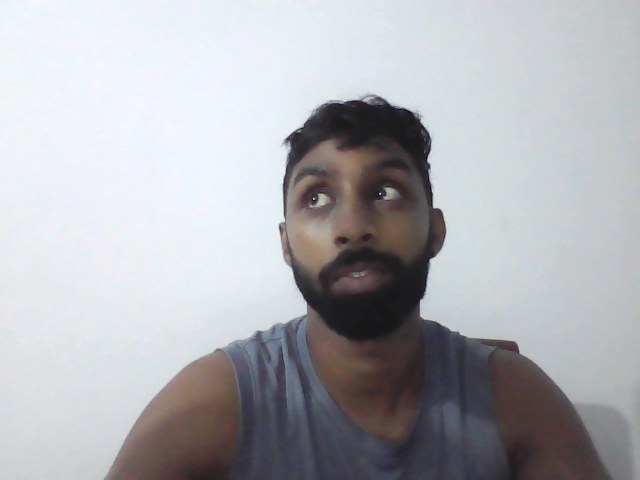

Image saved as D:\Other\People\Dula\Experiment\Local Jupyter/content/PersonImage/photo.jpg


In [13]:
import cv2
import PIL.Image

cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    cv2.imshow('Input', frame)

    c = cv2.waitKey(1)
    if (c == 27) or (c == 32):
        break
        

ret, frame = cap.read()
cap.release()
cv2.destroyAllWindows()

if ret:
    # Convert the OpenCV image to a format that can be displayed in IPython
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = PIL.Image.fromarray(frame_rgb)
    display(pil_image)
    
    # Save the captured image
    image_filename = person_image_folder_path + "/photo.jpg"
    cv2.imwrite(image_filename, frame)
    print(f"Image saved as {image_filename}")


## Capture Webcam image

In [14]:
# copy images from person image folder to background remover input folder
import shutil

# shutil.copytree(files(person_image_folder_path)[0], background_remover_input_folder_path, dirs_exist_ok=True)
src = person_image_folder_path + "/" + listFiles(person_image_folder_path)[0]
dest = background_remover_input_folder_path
shutil.copy(src, dest)

'D:\\Other\\People\\Dula\\Experiment\\Local Jupyter/content/MODNet/demo/image_matting/colab/input\\photo.jpg'

## Remove background of person's image

In [15]:
# %cd /content/MODNet
os.chdir(BASE_PATH + "/content/MODNet/")

!python -m demo.image_matting.colab.inference \
        --input-path demo/image_matting/colab/input \
        --output-path demo/image_matting/colab/output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt

Process image: photo.jpg


Displaying Background Removed Image

In [16]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))

  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)

  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined, image, foreground, matte * 255

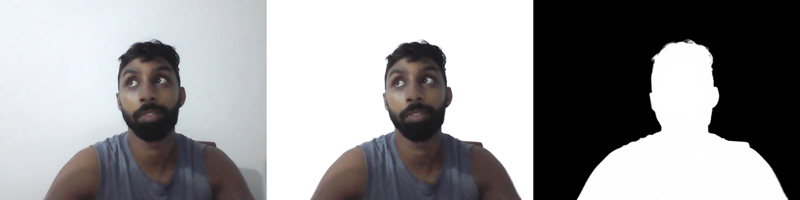

photo.jpg 



In [17]:
# visualize all images
image_names = os.listdir(background_remover_input_folder_path)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image = Image.open(os.path.join(background_remover_input_folder_path, image_name))
  matte = Image.open(os.path.join(background_remover_output_folder_path, matte_name))
  display(combined_display(image, matte)[0])
  print(image_name, '\n')

In [18]:
# Copy background removed image to Person image folder

person_mask = getFilesPathInFolder(background_remover_output_folder_path)[0]
person_mask_file = os.listdir(background_remover_output_folder_path)[0].split('.')

shutil.copyfile(person_mask, person_image_mask_folder_path + "/" + person_mask_file[0] + "-mask." + person_mask_file[1])

'D:\\Other\\People\\Dula\\Experiment\\Local Jupyter/content/PersonImageMask/photo-mask.png'

## Fetching background images with configuration

In [19]:
# Scan Google drive location for product(background) images or prompt for product images

In [20]:
import json
from IPython.display import Image

# %cd {products_image_path}
os.chdir(products_image_path)

if get_config_from_gdrive_file:
  with open(products_image_config_file_name, "r") as fid:
      productConfig = json.load(fid)
else :
  productConfig = json.loads(manualJsonConfig)

[{'imageName': 'pdchair.png', 'personImage': {'center': {'x': 521, 'y': 307}, 'size': {'max_width': 130, 'max_height': 194}}}, {'imageName': 'pdlamp.png', 'personImage': {'center': {'x': 483, 'y': 272}, 'size': {'max_width': 160, 'max_height': 160}}}, {'imageName': 'pdvase.png', 'personImage': {'center': {'x': 502, 'y': 547}, 'size': {'max_width': 193, 'max_height': 193}}}, {'imageName': 'pfan.png', 'personImage': {'center': {'x': 480, 'y': 399}, 'size': {'max_width': 160, 'max_height': 160}}}, {'imageName': 'pmilkpowder.png', 'personImage': {'center': {'x': 491, 'y': 509}, 'size': {'max_width': 242, 'max_height': 242}}}, {'imageName': 'pperfume.png', 'personImage': {'center': {'x': 500, 'y': 602}, 'size': {'max_width': 229, 'max_height': 229}}}, {'imageName': 'psmartphone.png', 'personImage': {'center': {'x': 505, 'y': 536}, 'size': {'max_width': 218, 'max_height': 218}}}, {'imageName': 'psmartwatch.png', 'personImage': {'center': {'x': 507, 'y': 785}, 'size': {'max_width': 103, 'max_

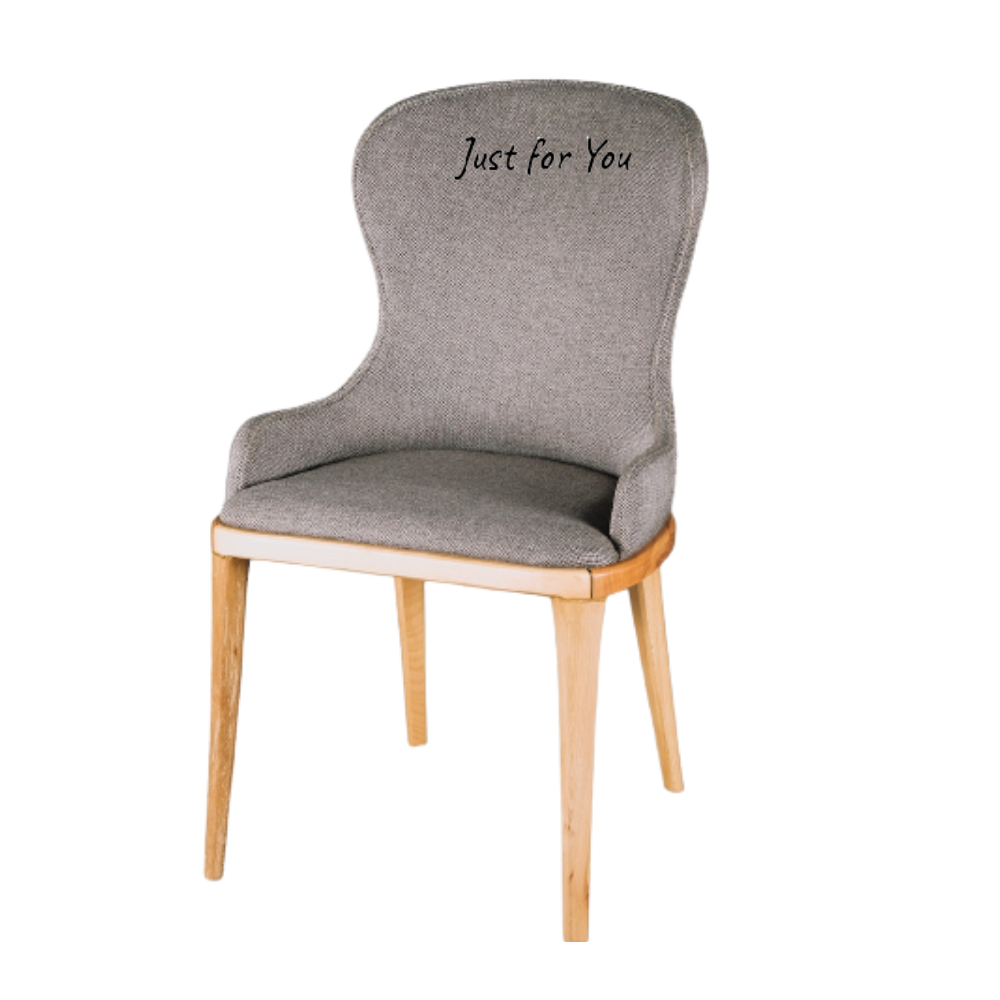

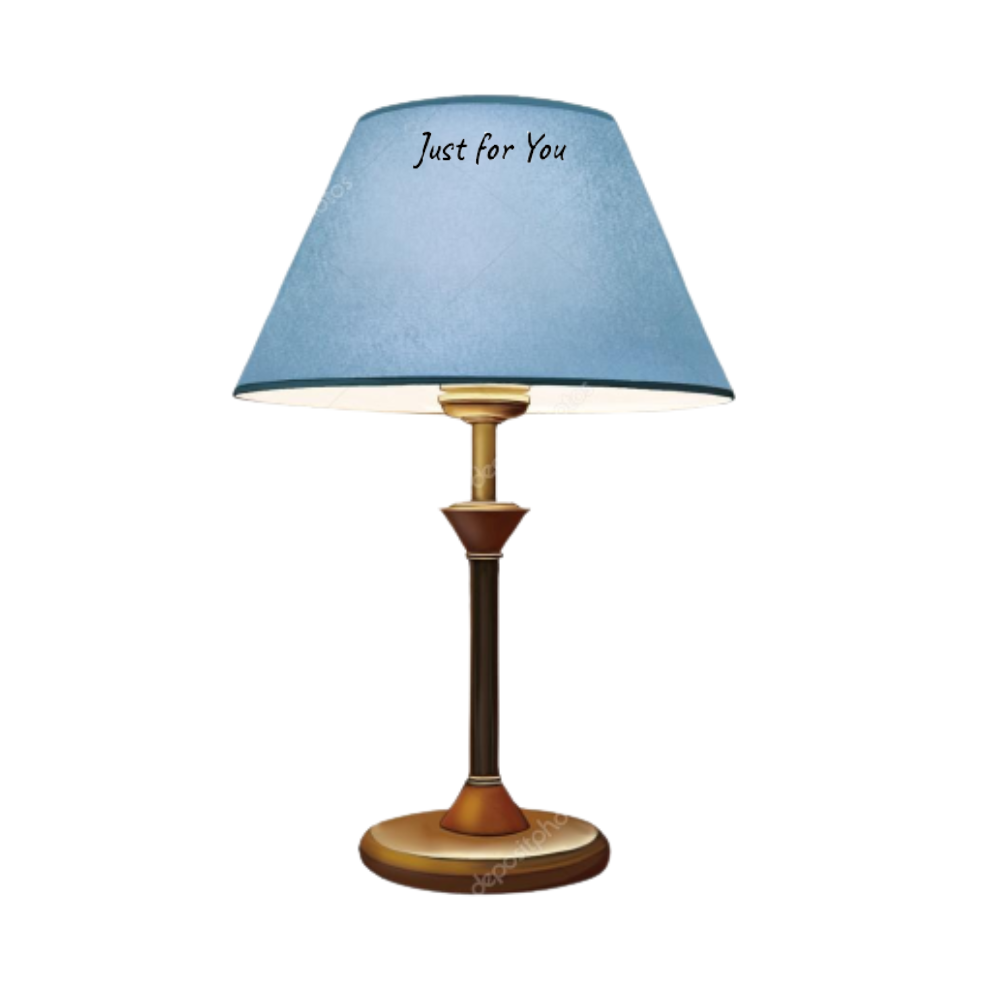

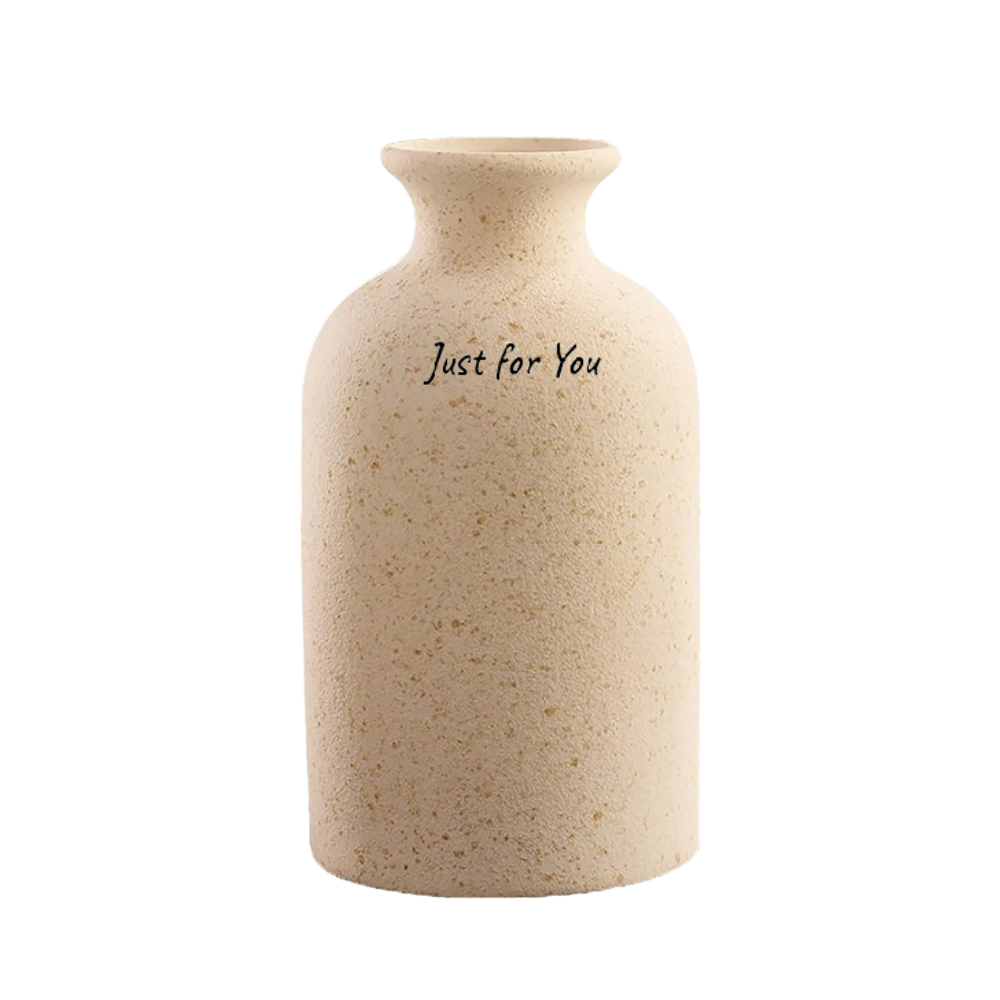

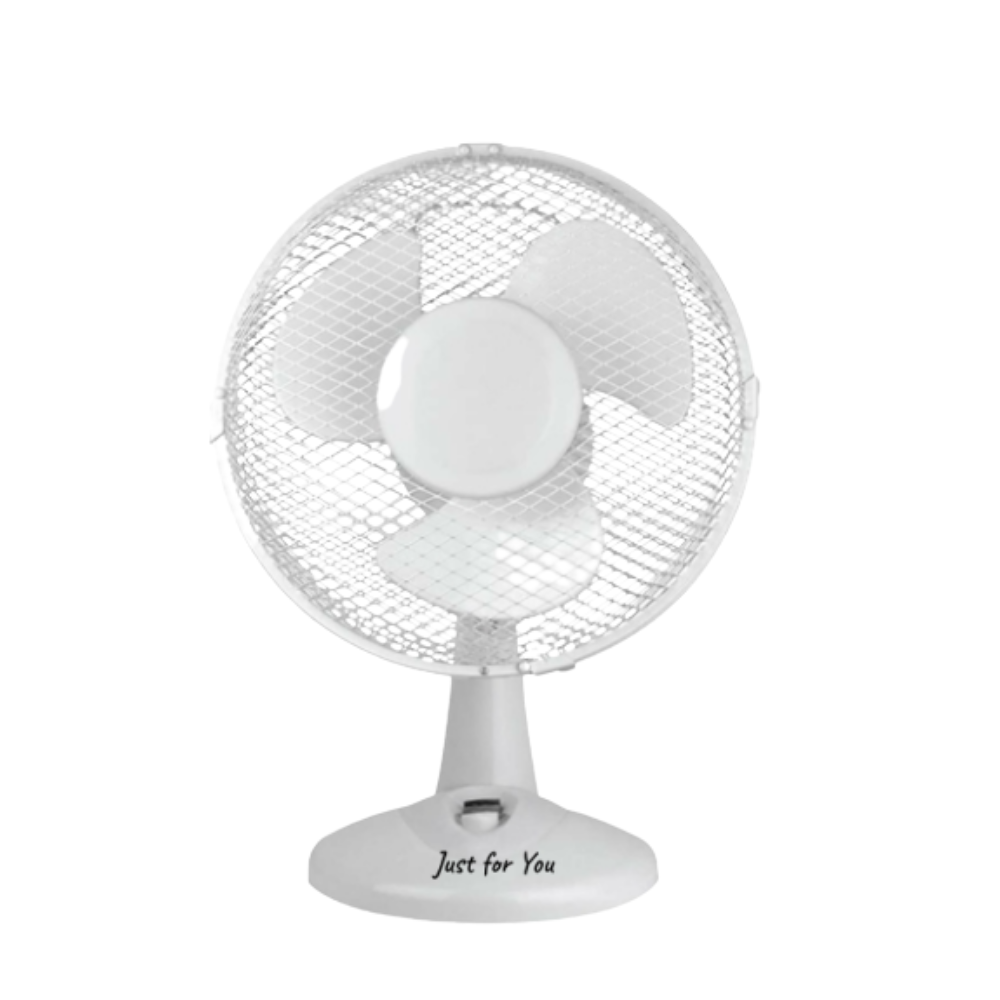

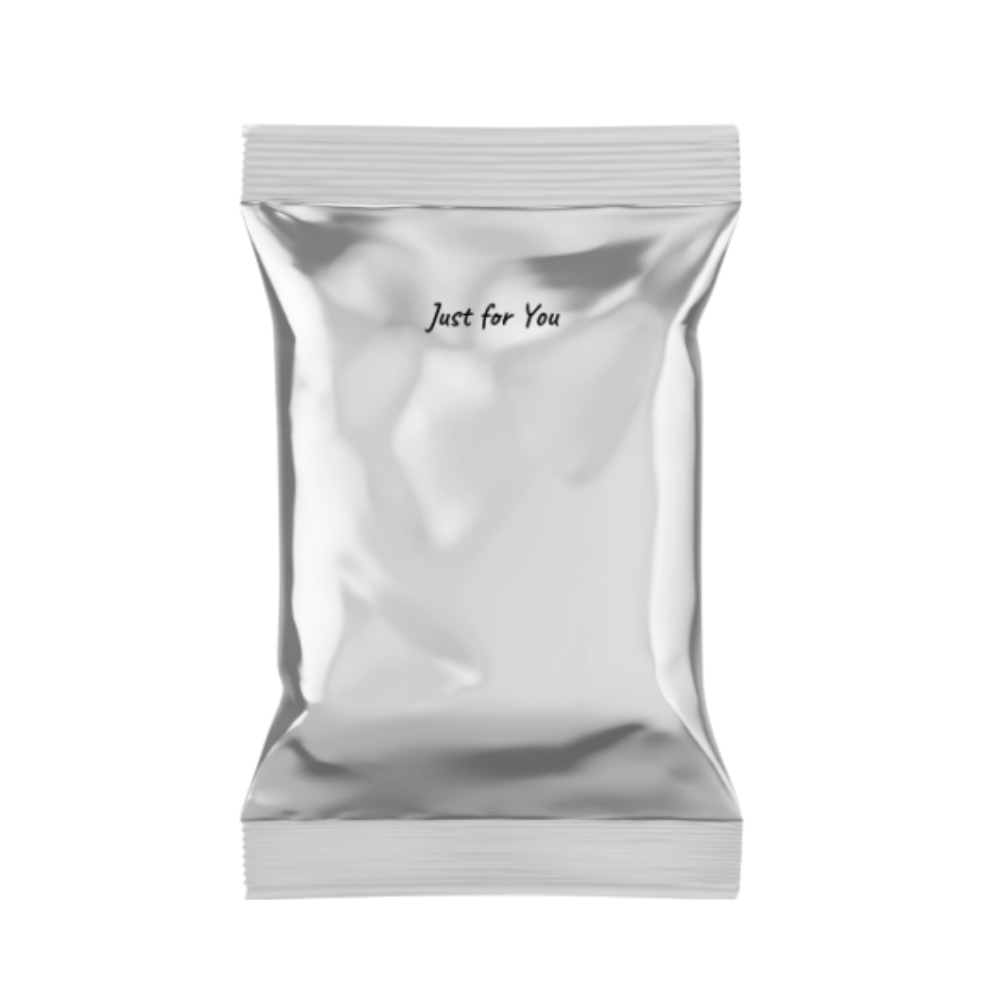

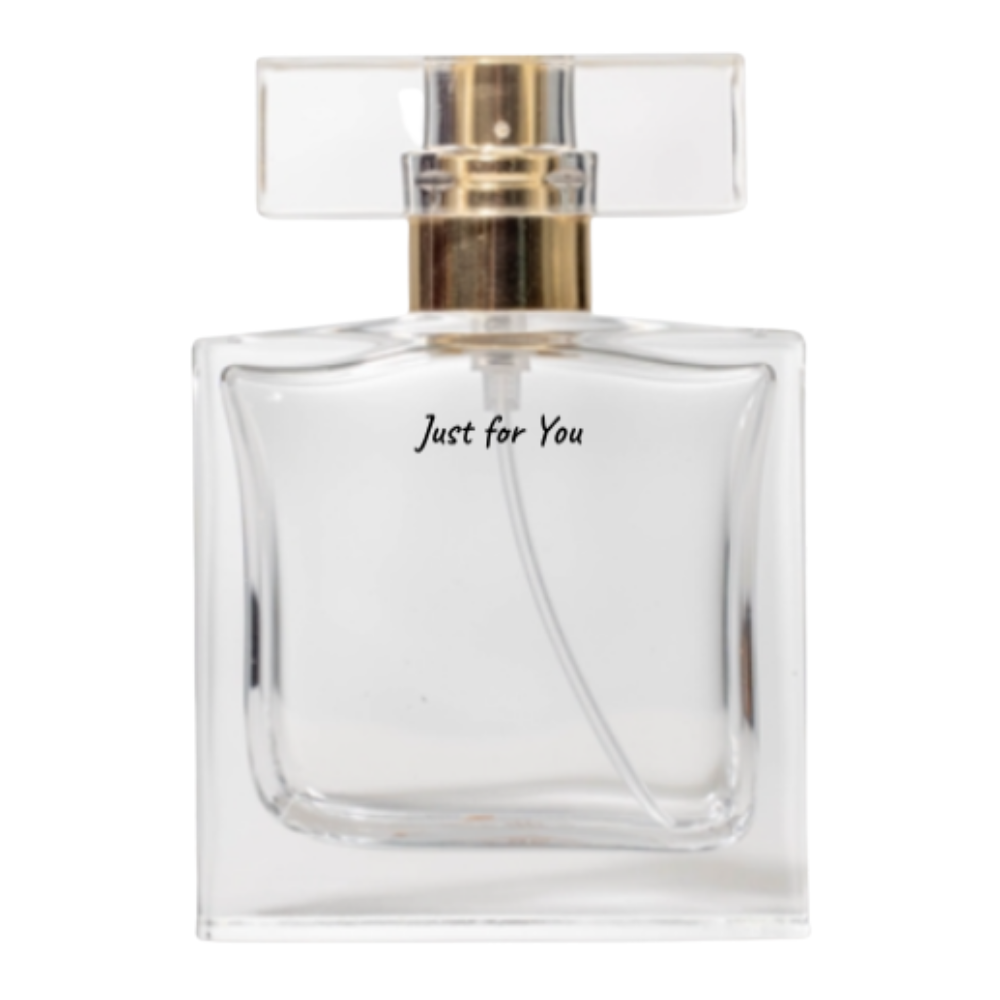

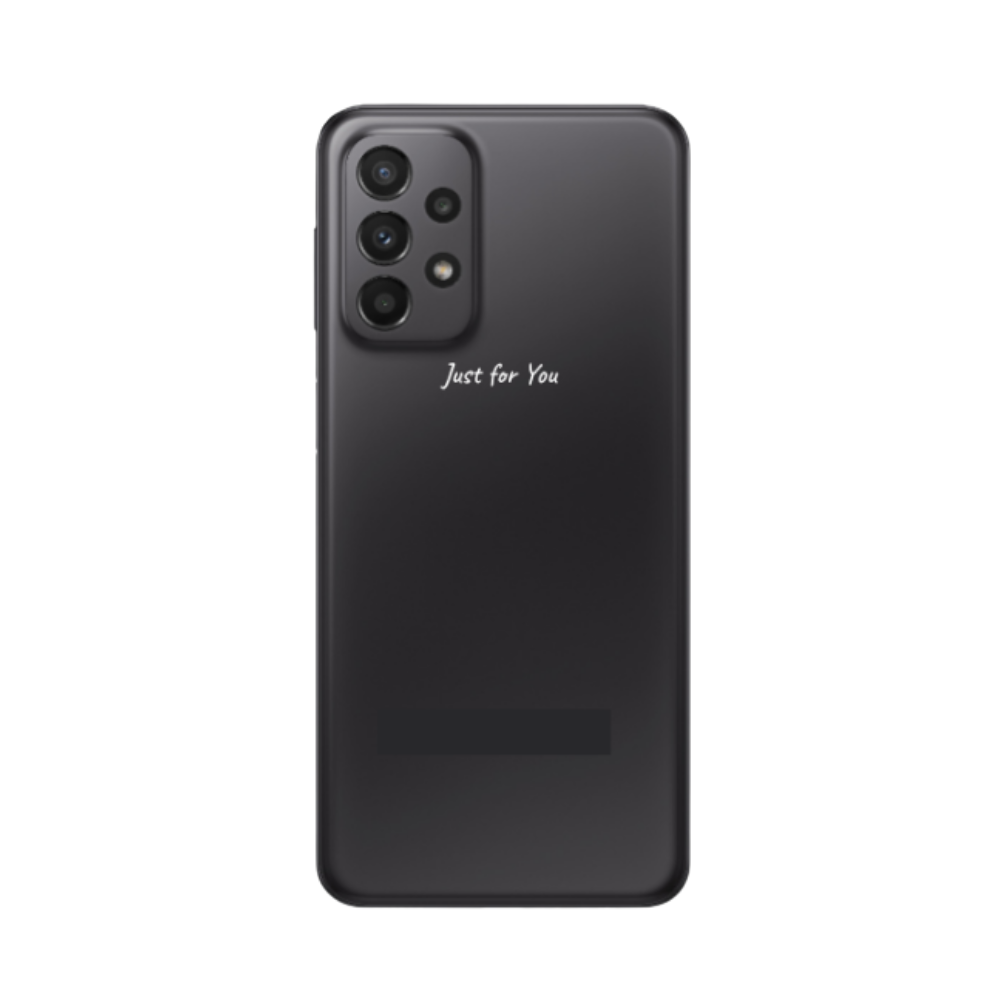

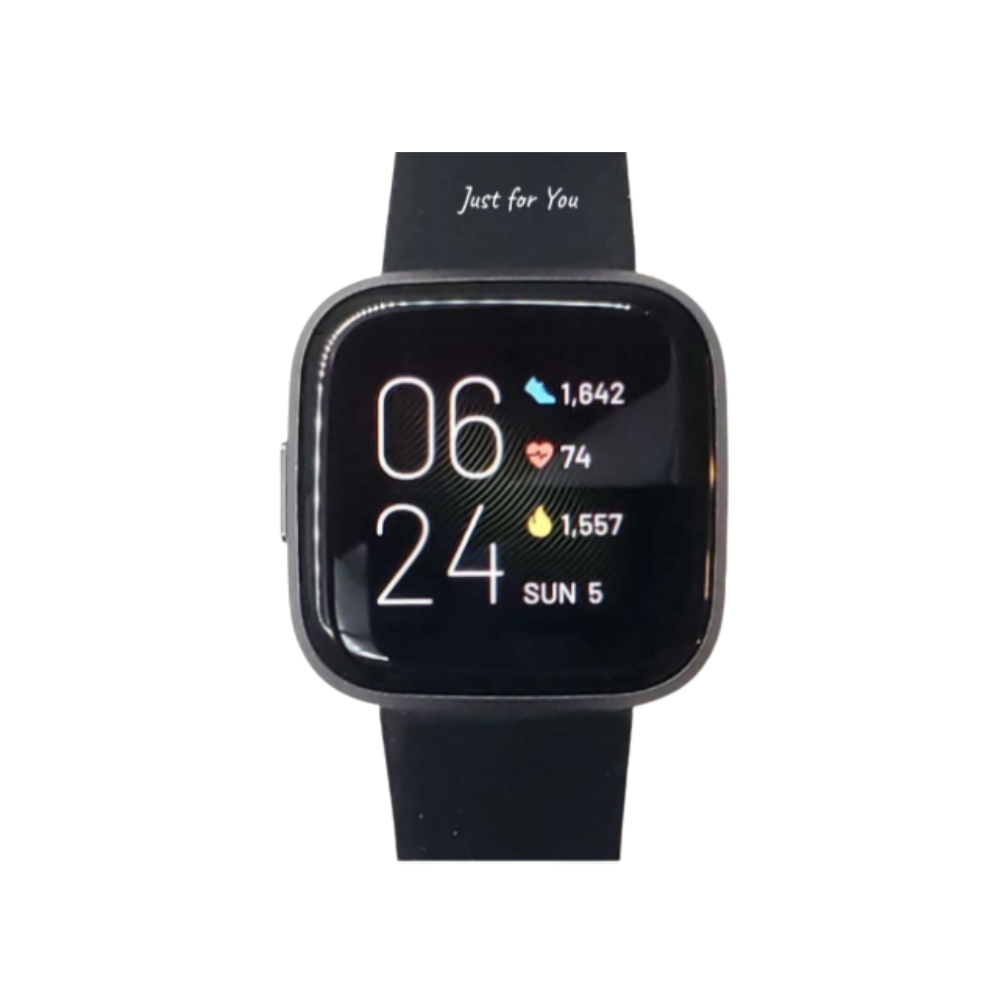

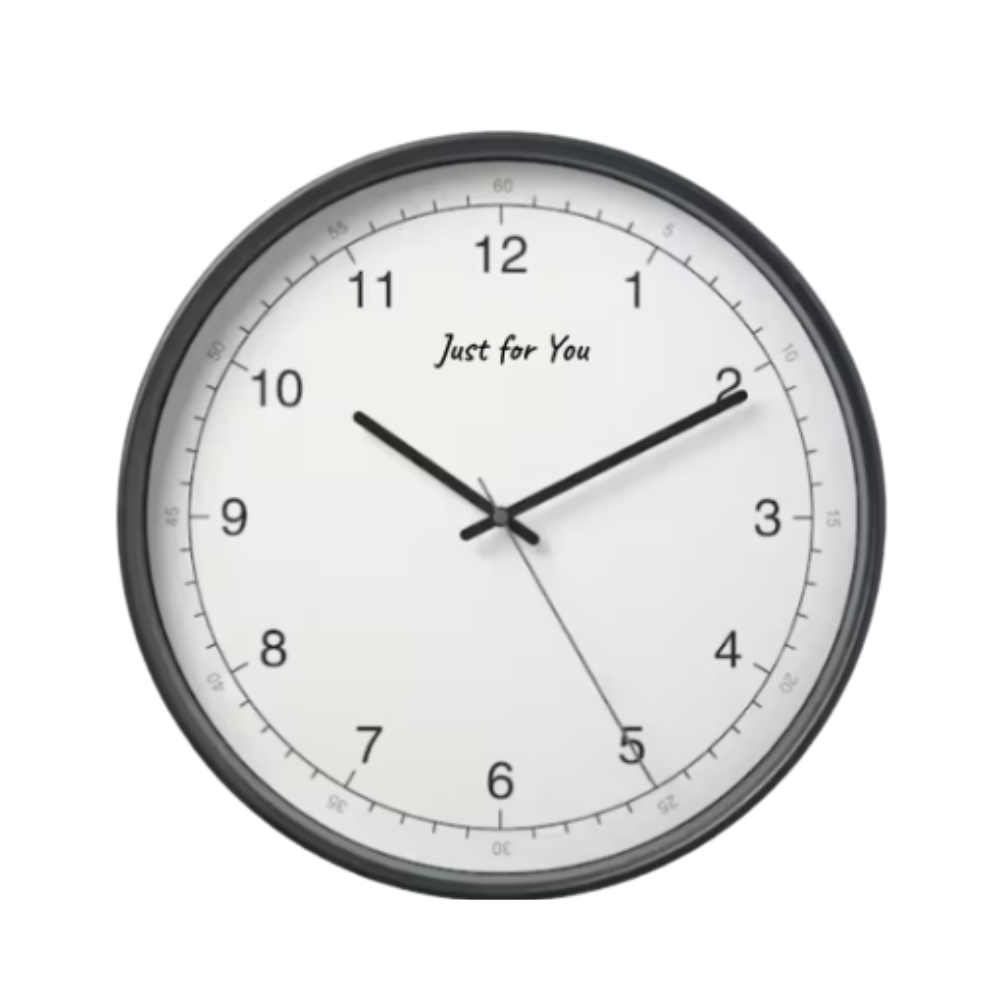

In [21]:
print(productConfig)

for product in productConfig:
    product_image = products_image_path + "/" + product["imageName"]
    display(Image(product_image))

## Retrieving person image and bg removal mask info

In [22]:
# Config person photo location for each product image

In [23]:
import cv2
# from google.colab.patches import cv2_imshow

person_image_name = os.listdir(person_image_folder_path)[0]
person_image_file = person_image_folder_path + "/" + person_image_name

person_image_split = person_image_name.split('.')
mask_image_name = person_image_split[0] + '-mask.png'
mask_image_file = person_image_mask_folder_path + "/" + mask_image_name

## Detect face in the image

In [24]:
import urllib.request
import cv2
import numpy as np
import os

# Load the face detection classifier
face_cascade = cv2.CascadeClassifier(face_detection_classifier_path)

# Read image
img = cv2.imread(person_image_file)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
single_face_info = faces[0]

(x,y,w,h) = single_face_info

## Merging face detection and background removal masks

In [25]:
# Face circal mask
center = (x + w//2, y + h//2)
radius = int(detected_face_radius_multiplier * w/2)
circular_face_mask = np.zeros_like(img)
_ = cv2.circle(circular_face_mask, center, radius, (255, 255, 255), -1, cv2.LINE_AA)

In [26]:
# BG removal mask
bg_removal_mask = cv2.imread(mask_image_file)

# Merge masks
merged_mask = cv2.bitwise_and(bg_removal_mask, circular_face_mask)

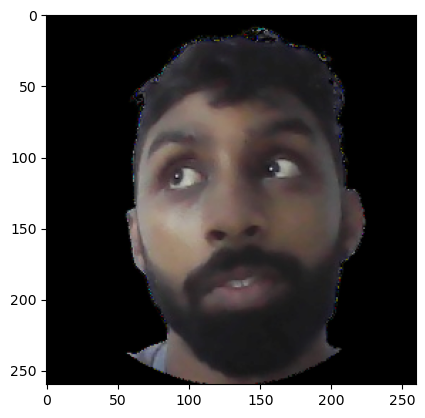

In [27]:
import cv2
from matplotlib import pyplot as plt

masked_img = cv2.bitwise_and(img, merged_mask)
(y1, y2) = (center[1] - radius, center[1] + radius)
(x1, x2) = (center[0] - radius, center[0] + radius)

# modify values to remove zero if avaliable
y1 = max(y1, 0)
y2 = max(y2, 0)
x1 = max(x1, 0)
x2 = max(x2, 0)

cropped_face_img = masked_img[y1:y2, x1:x2]
cropped_merged_mask = merged_mask[y1:y2, x1:x2]

# Display the cropped image
# cv2.imshow('', cropped_face_img)
pltImage = cv2.cvtColor(cropped_face_img, cv2.COLOR_BGR2RGB)
plt.imshow(np.array(pltImage))
plt.show()

## Loop through each product image and paste person image(background removed) into each product image

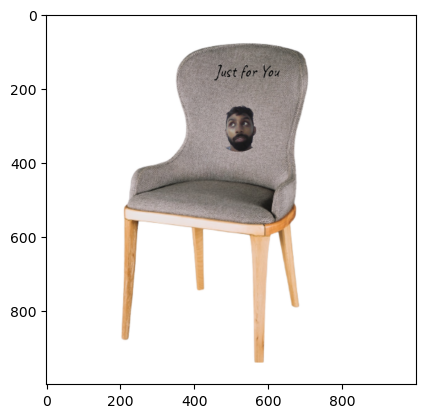

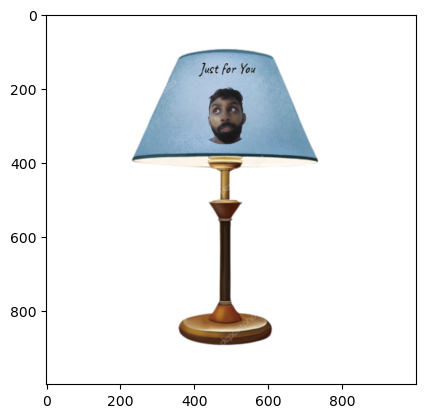

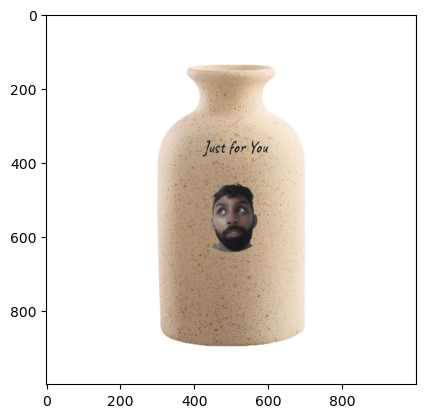

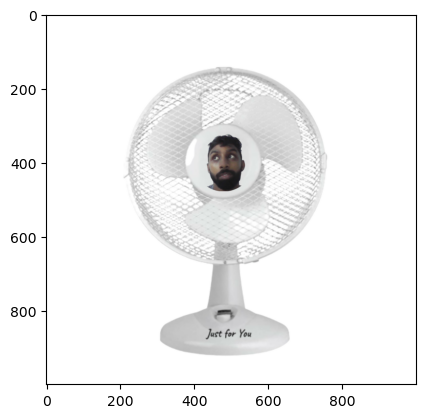

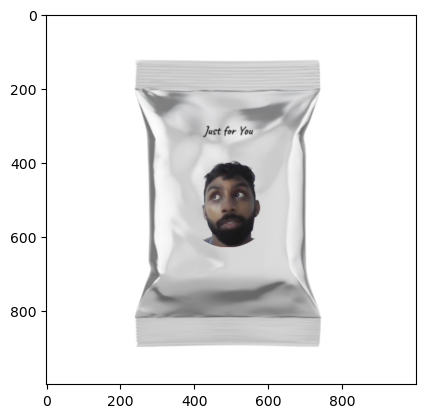

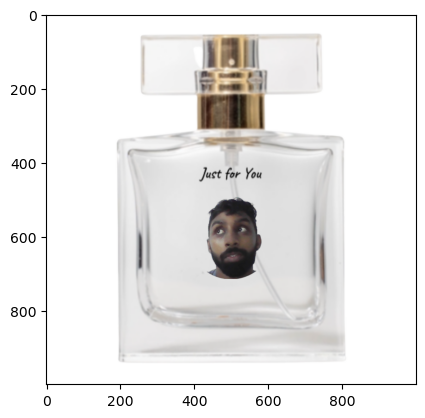

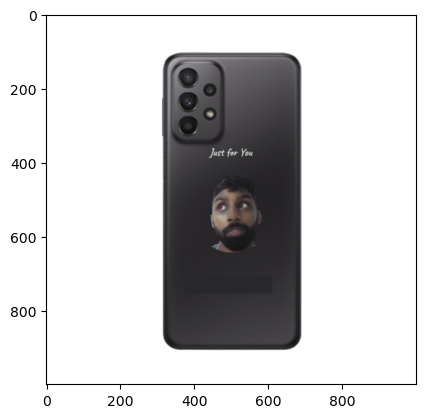

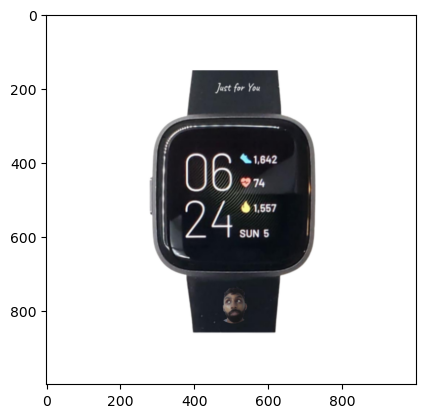

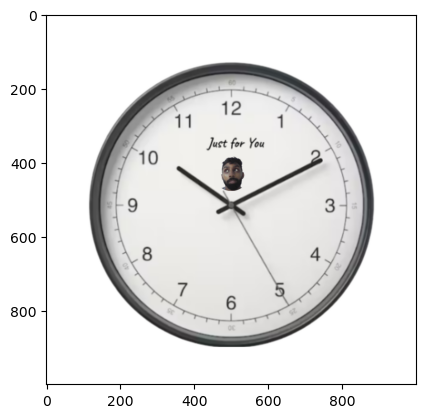

In [28]:
import copy
from matplotlib import pyplot as plt

for product in productConfig:

  if(product['personImage']):
    # Person face image & mask
    s_img_org = copy.copy(cropped_face_img)
    s_img = resize_image_with_max_height_and_width(
        s_img_org,
        max_width=product['personImage']['size']['max_width'],
        max_height=product['personImage']['size']['max_height']
    )

    mask_org = copy.copy(cropped_merged_mask)
    mask = resize_image_with_max_height_and_width(
        mask_org,
        max_width=product['personImage']['size']['max_width'],
        max_height=product['personImage']['size']['max_height']
    )

    # Background Image
    l_img = cv2.imread(products_image_path + "/" + product["imageName"], cv2.IMREAD_UNCHANGED)

    # New Image creation
    new_img = copy.copy(l_img)

    x_offset, y_offset = calculateOffset(product, s_img)

    y1, y2 = y_offset, y_offset + s_img.shape[0]
    x1, x2 = x_offset, x_offset + s_img.shape[1]

    alpha_s = mask[:,:,0] / 255.0
    alpha_l = 1.0 - alpha_s
    alpha_background_origina = l_img[:,:,3]

    for c in range(0, 3):
      new_img[y1:y2, x1:x2, c] = (alpha_s * s_img[:, :, c] + alpha_l * l_img[y1:y2, x1:x2, c])

    np.dstack([new_img, alpha_background_origina])
  else:
    # Background Image without personalization
    l_img = cv2.imread(products_image_path + "/" + product["imageName"], cv2.IMREAD_UNCHANGED)
    new_img = copy.copy(l_img)

#   cv2.imshow(new_img)
  pltImage = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
  plt.imshow(np.array(pltImage))
  plt.show()
  cv2.imwrite(os.path.join(personalized_image_output_path, product['imageName']), new_img)

## Download Personalized images

In [29]:
listFiles(person_image_folder_path)[0].split(".")[0] + '.zip'

'photo.zip'

In [30]:
# %cd /content
os.chdir(BASE_PATH)

zip_filename = listFiles(person_image_folder_path)[0].split(".")[0] + '.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)

os.system(f"zip -r -j {zip_filename} {personalized_image_output_path}/*")
# files.download(zip_filename)

shutil.make_archive("personalized_images", "zip", personalized_image_output_path)

'D:\\Other\\People\\Dula\\Experiment\\Local Jupyter\\personalized_images.zip'